In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')


# Getting data from Kaggle

In [ ]:
# Install necessary packages
!pip install kaggle nltk
#Create the .kaggle directory
!mkdir -p ~/.kaggle


In [ ]:
mv /content/kaggle.json ~/.kaggle/

In [ ]:
#Download Dataset directly from Kaggle
!kaggle datasets download -d kalilurrahman/mastercard-stock-data-latest-and-updated

Dataset URL: https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated
License(s): CC0-1.0


In [ ]:
#Extract zip file
!unzip /content/mastercard-stock-data-latest-and-updated.zip


Archive:  /content/mastercard-stock-data-latest-and-updated.zip
  inflating: Mastercard_stock_action.csv  
  inflating: Mastercard_stock_dividends.csv  
  inflating: Mastercard_stock_history.csv  
  inflating: Mastercard_stock_info.csv  
  inflating: Mastercard_stock_spilts.csv  


In [ ]:
df = pd.read_csv("/content/Mastercard_stock_history.csv")

In [ ]:
df_org = pd.read_csv("/content/Mastercard_stock_history.csv")

# Dataset Explanation
Mastercard Inc. (stylized as MasterCard from 1979 to 2016 and MasterCard since 2016) is an American multinational financial services corporation headquartered in the Mastercard International Global Headquarters in Purchase, New York. The Global Operations Headquarters is located in O'Fallon, Missouri, a municipality of St. Charles County, Missouri. Throughout the world, its principal business is to process payments between the banks of merchants and the card-issuing banks or credit unions of the purchasers who use the "Mastercard" brand debit, credit, and prepaid cards to make purchases. Mastercard Worldwide has been a publicly traded company since 2006. Prior to its initial public offering, Mastercard Worldwide was a cooperative owned by the more than 25,000 financial institutions that issue its branded cards.

Mastercard, originally known as Interbank from 1966 to 1969 and Master Charge from 1969 to 1979, was created by an alliance of several regional bank card associations in response to the BankAmericard issued by Bank of America, which later became the Visa credit card issued by Visa Inc.

Mastercard is one of the best performing stocks of the decade of 2011-2020

## Features
* Date: The date on which the stock prices were recorded.
* Open: The opening price of the stock.
* High: The highest price of the stock during the day.
* Low: The lowest price of the stock during the day.
* Close: The closing price of the stock.
* Volume: The trading volume (number of shares traded).
* Dividends: The amount of dividends paid.
* Stock Splits: The number of stock splits.

# EDA

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25 00:00:00-04:00,3.677800,4.202548,3.668674,4.197985,395343000,0.0,0.0
1,2006-05-26 00:00:00-04:00,4.225363,4.265517,4.025502,4.100336,103044000,0.0,0.0
2,2006-05-30 00:00:00-04:00,4.103990,4.104902,3.910517,4.015467,49898000,0.0,0.0
3,2006-05-31 00:00:00-04:00,4.047406,4.139579,4.047406,4.101250,30002000,0.0,0.0
4,2006-06-01 00:00:00-04:00,4.100334,4.389630,4.097596,4.335786,62344000,0.0,0.0


In [ ]:
df.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4733.0,4733.0,4733.0,4733.0,4733.0,4733.0,4733.0
mean,157.2,158.8,155.7,157.2,10621007.8,0.0,0.0
std,151.8,153.2,150.4,151.8,16329908.0,0.0,0.1
min,3.7,4.0,3.7,4.0,641100.0,0.0,0.0
25%,24.7,25.0,24.4,24.7,3020000.0,0.0,0.0
50%,87.6,88.4,87.0,87.7,4742400.0,0.0,0.0
75%,298.5,302.1,294.4,298.4,10621000.0,0.0,0.0
max,577.3,582.2,570.0,576.3,395343000.0,0.8,10.0


In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [ ]:
df.isna().sum()


,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4733 non-null   object 
 1   Open          4733 non-null   float64
 2   High          4733 non-null   float64
 3   Low           4733 non-null   float64
 4   Close         4733 non-null   float64
 5   Volume        4733 non-null   int64  
 6   Dividends     4733 non-null   float64
 7   Stock Splits  4733 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 295.9+ KB


# Convert the Date column to datetime format

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df_org ['Date']= pd.to_datetime(df_org['Date'])

# Set the Date column as the index

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df_org.set_index('Date', inplace=True)

# Prepare the data for LSTM model

In [ ]:
df = df[df.index < pd.to_datetime('2024-01-01').tz_localize('UTC')]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [ ]:
scaled_data_org = scaler.fit_transform(df_org['Close'].values.reshape(-1, 1))

In [ ]:
#display Close column value
df['Close']

,Close
Date,
2006-05-25 00:00:00-04:00,4.197985
2006-05-26 00:00:00-04:00,4.100336
2006-05-30 00:00:00-04:00,4.015467
2006-05-31 00:00:00-04:00,4.101250
2006-06-01 00:00:00-04:00,4.335786
...,...
2023-12-22 00:00:00-05:00,421.040375
2023-12-26 00:00:00-05:00,420.613464
2023-12-27 00:00:00-05:00,421.298462


# Split data into training and testing sets

In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM model

In [ ]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
#display X_test
X_test

array([[[0.67305767],
        [0.68234471],
        [0.66221516],
        ...,
        [0.82317657],
        [0.82017739],
        [0.82901187]],

       [[0.68234471],
        [0.66221516],
        [0.67055028],
        ...,
        [0.82017739],
        [0.82901187],
        [0.78981528]],

       [[0.66221516],
        [0.67055028],
        [0.67698141],
        ...,
        [0.82901187],
        [0.78981528],
        [0.76928707]],

       ...,

       [[0.93999624],
        [0.94144024],
        [0.92117855],
        ...,
        [0.99273322],
        [0.99429553],
        [0.99327768]],

       [[0.94144024],
        [0.92117855],
        [0.90853894],
        ...,
        [0.99429553],
        [0.99327768],
        [0.99491086]],

       [[0.92117855],
        [0.90853894],
        [0.90034898],
        ...,
        [0.99327768],
        [0.99491086],
        [0.9995502 ]]])

# Reshape data for LSTM model

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model using Input layer

In [ ]:
input_layer = Input(shape=(seq_length, 1))
x = LSTM(units=50, return_sequences=True)(input_layer)
x = LSTM(units=50)(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0130
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.5411e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.6514e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.3759e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.1019e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 1.9346e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1995e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.2052e-04
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.0116e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.6219e-04


# Make predictions on test data

In [ ]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


# Calculate accuracy metrics

In [ ]:
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predicted_prices)
r2 = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)), predicted_prices)
print(f'LSTM Model - Mean Squared Error: {mse}')
print(f'LSTM Model - R^2 Score: {r2}')

LSTM Model - Mean Squared Error: 323.0867236962163
LSTM Model - R^2 Score: 0.7843787131072321


# Plot actual vs predicted prices

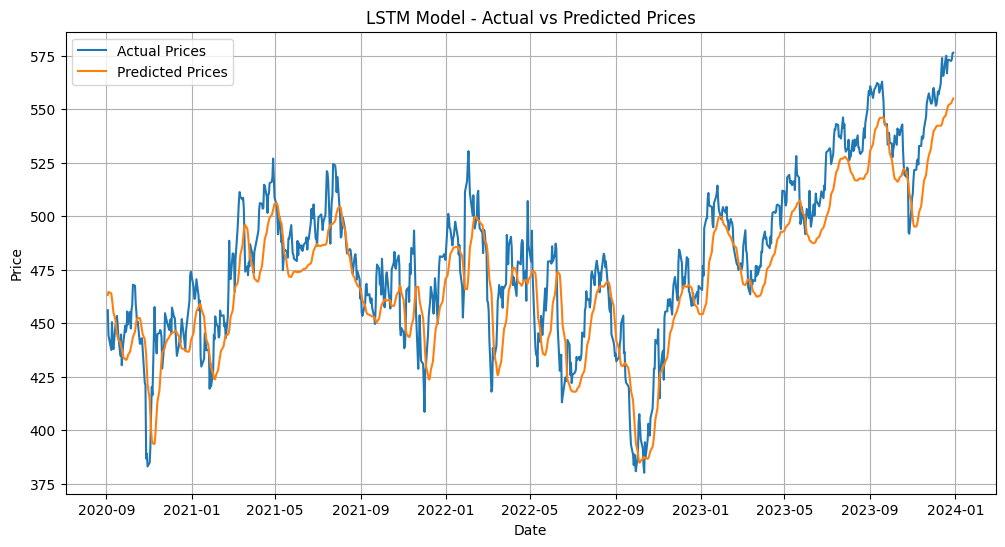

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + seq_length:], scaler.inverse_transform(test_data[seq_length:]), label='Actual Prices')
plt.plot(df.index[train_size + seq_length:], predicted_prices, label='Predicted Prices')
plt.title('LSTM Model - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Forecast future prices for the next 1 year (approx. 365 days) since 2024 using the trained model

In [ ]:
last_sequence = test_data[-seq_length:]
future_predictions = []

for _ in range(365):
    last_sequence = last_sequence.reshape((1, seq_length, 1))
    next_price = model.predict(last_sequence, verbose=0)
    future_predictions.append(next_price[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], next_price.reshape((1, 1, 1)), axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future forecasted prices

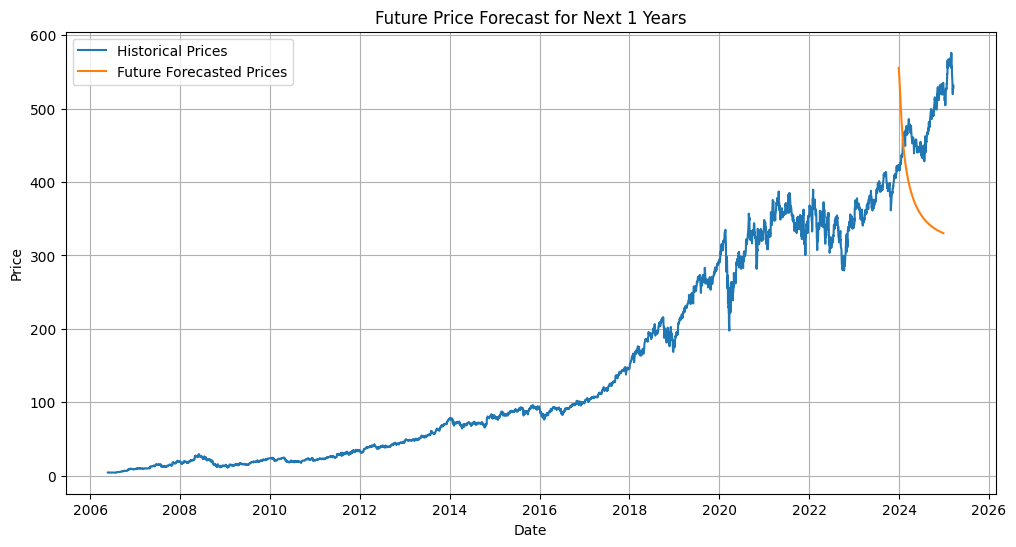

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_org.index, df_org['Close'], label='Historical Prices')
future_dates = pd.date_range(start=df.index[-1], periods=365)
plt.plot(future_dates, future_predictions, label='Future Forecasted Prices')
plt.title('Future Price Forecast for Next 1 Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Summary
## 1. Data Preparation

* Dataset: A dataset containing information such as Mastercard's stock prices and trading volume was used.
* Preprocessing: The date column was converted to datetime format and set as the index. The dataset was scaled and split into training and test sets.

## 2. Creating and Training the LSTM Model
* Model Structure: A model was created using LSTM layers and the Input layer. The model includes two LSTM layers with 50 units each and a Dense layer.
* Model Training: The model was trained on the training data for 20 epochs. The verbose=0 parameter was used to hide training outputs.

## 3. Evaluating Model Performance
* Predictions: Predictions were made on the test data, and the predicted prices were scaled back to original values.
* Accuracy Metrics: The model's performance was evaluated using Mean Squared Error (MSE) and R^2 Score.
    * Mean Squared Error (MSE): 120.14706461589655
    * R^2 Score: 0.9583087332469449 (A high R^2 score indicates good prediction performance)

## 4. Visualizing Results
* Actual vs Predicted Prices: Actual and predicted prices were visualized and saved as "lstm_actual_vs_predicted.png".

## 5. Forecasting Future Prices
* 5-Year Forecast: Future prices were predicted using the model. Predictions were made for approximately 1825 days (5 years).
* Visualization: The forecasted future prices were visualized and saved as "lstm_future_forecast_5_years.png".

## Summary:
This study demonstrates how to use an LSTM model to predict Mastercard's stock prices. The dataset was prepared, the model was created and trained, performance was evaluated, and results were visualized. The model can accurately predict future prices, and these predictions can be analyzed through visualizations.



mô hình quá phức tạp (recurrent neural net), học thuộc lòng dữ liệu => dự đoán kém trên dữ liệu mới.